# Value at Risk
There are several methods to evaluate risk for an individual stock or a portfolio, such as variance, standard deviation of returns, et al. But, those measures do not consider a probability distribution. However, many risk managers prefer a simple measure called Value at Risk (VaR). VaR is one of the most important metrics that is used to measure the risk associated with a financial position or a portfolio of financial instruments and can be defined as the maximum loss with a confidence level over a predetermined period.

Let's say that the 1-day $95 \%$ VaR of our portfolio is $\$ 100$. This means that $95 \%$ of the time, it is expected that - under normal market conditions - we will not lose more than $\$ 100$ by holding our portfolio over one day.

Three approaches that are commonly used in the industry are

* Parametric

* Historical

* Monte Carlo

In [79]:
# Import libraries
import pandas as pd
import numpy as np
import datetime
from pprint import pprint
from collections import OrderedDict
from numpy.linalg import multi_dot
import scipy.stats as ss
import yfinance as yf
import plotly.express as px

# Configurations
px.defaults.template = "plotly_white"
px.defaults.width, px.defaults.height = 1000, 600

## Retrieve Data
We'll get data from yahoo finance

In [80]:
assets = ['AAPL', 'MSFT', 'AMZN', 'GOOG']

# Start date, end date and trading days in a year
end_date = datetime.datetime(2018, 12, 31)
start_date = end_date - datetime.timedelta(days=365)
TRADING_DAYS = 252

# Download the data
# df = pd.read_csv('asset_close_prices.csv', index_col=0, parse_dates=True)
df = yf.download(assets, start=start_date, end=end_date)['Adj Close']
df.head()

[*********************100%***********************]  4 of 4 completed


,AAPL,AMZN,GOOG,MSFT
Date,,,,
2018-01-02,40.831585,59.450500,53.250000,80.562057
2018-01-03,40.824474,60.209999,54.124001,80.936974
2018-01-04,41.014103,60.479500,54.320000,81.649345
2018-01-05,41.481060,61.457001,55.111500,82.661629
2018-01-08,41.326988,62.343498,55.347000,82.745979


In [81]:
# Calculte daily returns
returns = df.pct_change().dropna()
returns.head()

,AAPL,AMZN,GOOG,MSFT
Date,,,,
2018-01-03,-0.000174,0.012775,0.016413,0.004654
2018-01-04,0.004645,0.004476,0.003621,0.008802
2018-01-05,0.011385,0.016163,0.014571,0.012398
2018-01-08,-0.003714,0.014425,0.004273,0.001020
2018-01-09,-0.000115,0.004676,-0.000614,-0.000680


In [82]:
# Plot histogram of daily returns
px.histogram(returns, nbins=100 ,histnorm='probability density', title='Histogram of daily returns', barmode='relative')

## Parametric VaR

The Variance-covariance is a parametric method which assumes (almost
always) that the returns are normally distributed. In this method, we
first calculate the mean and standard deviation of the returns to derive
the risk metric. Based on the assumption of normality, we can
generalise, $V a R=$ position $*(\mu-z * \sigma)$

<div class="center">

| Confidence Level | Value At Risk     |
|:-----------------|:------------------|
| 90%              | *μ* − 1.29 \* *σ* |
| 95%              | *μ* − 1.64 \* *σ* |
| 99%              | *μ* − 2.33 \* *σ* |

</div>

In [83]:
# Stock returns
stock_returns = returns['GOOG']

# Calculate mean and standard deviation
mean = stock_returns.mean()
std = stock_returns.std()

# Calculate the VaR at different confidence intervals
VaR_90 = ss.norm.ppf(1-0.9, mean, std)
VaR_95 = ss.norm.ppf(1-0.95, mean, std)
VaR_99 = ss.norm.ppf(1-0.99, mean, std)

In [84]:
# Number of standard deviations from the mean
ss.norm.ppf(0.01)

-2.3263478740408408

In [85]:
# Output the results as a dataframe
results = pd.DataFrame({'Confidence Level': ['90%', '95%', '99%'], 'Value at Risk': [VaR_90, VaR_95, VaR_99]})
results.head()

,Confidence Level,Value at Risk
0,90%,-0.022708
1,95%,-0.029160
2,99%,-0.041263


### Normality Test

In the Parametric VaR, we assumed that the returns are normally
distributed. However, in the real world, we know that stock / portfolio
returns do not necessarily follow a normal distribution. Let’s perform a
quick check to determine the normality of the underlying returns and see
whether we need to modify our approach in deriving the VaR numbers.

**Shapiro** The Shapiro-Wilk test is a test of normality and is used to
determine whether or not a sample comes from a normal distribution.

In [86]:
# Normality test
ss.shapiro(stock_returns)

ShapiroResult(statistic=0.9694290161132812, pvalue=3.503906918922439e-05)

Our null hypothesis is that HDFCBank stock daily returns follows a normal distribution. Since the p-value is less than 0.05 , we reject the null hypothesis. We have sufficient evidence to say that the sample data does not come from a normal distribution. This result shouldn't be surprising as the data comes from an empirical distribution.

**Anderson-Darling** Alternatively, we can perform an Anderson-Darling Test. It is a goodness of fit test that measures how well the data fit a specified distribution. This test is most commonly used to determine whether or not the data follow a normal distribution.

In [87]:
# Normality test using Anderson-Darling test
ss.anderson(stock_returns)

AndersonResult(statistic=2.3158675871839876, critical_values=array([0.567, 0.646, 0.775, 0.904, 1.075]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=5.1111247933574766e-05, scale=0.01775909530598509)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Based on the above result, the null hypothesis is rejected since the
test statistic value is much higher than the critical value of 1.09 even
at 1% significance level.

## Modified VaR

Standard normal distribution have a zero mean, unit variance, zero
skewness, and its kurtosis of 3. However, we now know the distribution
is not normal and in such scenario, the skewness and excess kurtosis of
many stock returns are not zero. As a consequence, the modified VaR was
developed to utilize those four moments instead of the first two
moments.

$$
m V a R=\text { position } *(\mu-t * \sigma)
$$

where,

$$
t=z+\frac{1}{6}\left(z^{2}-1\right) s+\frac{1}{24}\left(z^{3}-3 z\right) k-\frac{1}{36}\left(2 z^{3}-5 z\right) s^{2}
$$

$\mu$ is the return, $\sigma$ is the volatility, $s$ is the skewness, $k$ is the kurtosis and $z$ is the absolute number of standard deviation from the mean.

In [88]:
# First four momemnts
dist = OrderedDict({
    'Mean': np.mean(returns['GOOG']),
    'Variance': np.std(returns['GOOG']),
    'Skew': ss.skew(returns['GOOG']),
    'Kurtosis': ss.kurtosis(returns['GOOG'])
})
print(dist)

OrderedDict([('Mean', 5.1111247933574766e-05), ('Variance', 0.01772339859591053), ('Skew', -0.3507972064169087), ('Kurtosis', 1.237585177851991)])


In [89]:
# Specify parameters for modified VaR
z = abs(ss.norm.ppf(0.01))
s = ss.skew(stock_returns)
k = ss.kurtosis(stock_returns)
t = z+1/6*(z**2-1)*s+1/24*(z**3-3*z)*k-1/36*(2*z**3-5*z)*s**2

# Calculate VaR at difference confidence level
modified_VaR_99 = (mean - t * std)
print(modified_VaR_99)

-0.04099764822918054


## Historical VaR

Asset returns do not necessarily follow a normal distribution. An
alternative is to use sorted returns to evaluate a VaR. This method uses
historical data where returns are sorted in ascending order to calculate
maximum possible loss for a given confidence level.

In [90]:
# Use quantile function for Historical VaR
hVaR_90 = returns['GOOG'].quantile(0.10)
hVaR_95 = returns['GOOG'].quantile(0.05)
hVaR_99 = returns['GOOG'].quantile(0.01)

# Output the results
print("Historical VaR 90%: ", hVaR_90)
print("Historical VaR 95%: ", hVaR_95)
print("Historical VaR 99%: ", hVaR_99)

Historical VaR 90%:  -0.022375711473277902
Historical VaR 95%:  -0.03100402478096662
Historical VaR 99%:  -0.04917684560289655


## Monte Carlo VaR

The Monte Carlo simulation approach has a number of similarities to
historical simulation. It allows us to use actual historical
distributions rather than having to assume normal returns. As returns
are assumed to follow a normal distribution, we could generate *n*
simulated returns with the same mean and standard deviation (derived
from the daily returns) and then sorted in ascending order to calculate
maximum possible loss for a given confidence level. \[ \]: \# Set seed
for reproducibility

In [91]:
# Set seed for reproducibility
np.random.seed(42)

# Number of simulations
n_sims = 5000

# Simulate returns and sort
sim_returns = np.random.normal(mean, std, n_sims)

# Use percentile function for MCVaR
MCVaR_90 = np.percentile(sim_returns,10)
MCVaR_95 = np.percentile(sim_returns, 5)
MCVaR_99 = np.percentile(sim_returns, 1)

# Print the results
print("MCVaR 90%:", round(MCVaR_90, 4))
print("MCVaR 95%:", round(MCVaR_95, 4))
print("MCVaR 99%:", round(MCVaR_99, 4))

MCVaR 90%: -0.0225
MCVaR 95%: -0.0286
MCVaR 99%: -0.0419


## Scaling VaR

Now, let’s calculate VaR over a 5-day period. To scale it, multiply by
square root of time.

$$
V a R=\text { position } *(\mu-z * \sigma) * \sqrt{T}
$$

where, $T$ is the horizon or forecast period.

In [92]:
# VaR Scaling over a 5 day period
forecast_days = 5
f_VaR_90 = VaR_90*np.sqrt(forecast_days)
f_VaR_95 = VaR_95*np.sqrt(forecast_days)
f_VaR_99 = VaR_99*np.sqrt(forecast_days)

# Print the results
print("Scaled Forecast VaR 90%: ", f_VaR_90)
print("Scaled Forecast VaR 95%: ", f_VaR_95)
print("Scaled Forecast VaR 99%: ", f_VaR_99)

Scaled Forecast VaR 90%:  -0.050776822021077216
Scaled Forecast VaR 95%:  -0.06520374463324116
Scaled Forecast VaR 99%:  -0.09226625213820763


In [93]:
# Plot Scaled VaR
sVaR = pd.DataFrame([-100*VaR_99*np.sqrt(x) for x in range(100)], columns=['Scaled VaR'])
px.scatter(sVaR, sVaR.index, sVaR['Scaled VaR'], title='Scaled VaR', labels={'index': 'Horizon'})

## Expected Short Fall

$\mathrm{VaR}$ is a reasonable measure of risk if assumption of normality holds. Else, we might underestimate the risk if we observe a fat tail or overestimate the risk if tail is thinner. Expected shortfall or Conditional Value at Risk - **CVaR** - is an estimate of expected shortfall sustained in the worst 1 - $x \%$ of scenarios. It is defined as the average loss based on the returns that are lower than the VaR threshold. Assume that we have $n$ return observations, then the expected shortfall is

$$
C V a R=\frac{1}{n} * \sum_{i=1}^{n} R_{i}\left[R \leq h V a R_{c l}\right]
$$

where, $R$ is returns, $h V a R$ is historical VaR and $c l$ is the confidence level.

In [94]:
# Calculate CVar
CVaR_90 = returns['GOOG'][returns['GOOG']<=hVaR_90].mean()
CVaR_95 = returns['GOOG'][returns['GOOG']<=hVaR_95].mean()
CVaR_99 = returns['GOOG'][returns['GOOG']<=hVaR_99].mean()

# Print results
print(f'CVaR 90%: {CVaR_90}')
print(f'CVaR 95%: {CVaR_95}')
print(f'CVaR 99%: {CVaR_99}')

CVaR 90%: -0.03551203044245563
CVaR 95%: -0.04392068167184237
CVaR 99%: -0.050431196890269536


## Portfolio VaR
If we know the returns and volatilities of all the assets in the portfolio, we can derive portfolio VaR. We will now derive VaR of minimum variance portfolio consisting of Indian stocks.

In [95]:
# Weights from Minimum Variance Portfolio
weights = np.array([1.928e-01, 2.367e-01, 2.099e-01, 7.286e-02])

# Portfolio mean returns and volatility
port_mean = weights.T @ returns.mean()
port_stdev = np.sqrt(multi_dot([weights.T, returns.cov(), weights]))
pVaR = ss.norm.ppf(1-0.99, port_mean, port_stdev)
print(f"Mean: {port_mean}, Std: {port_stdev}, Portfolio VaR: {pVaR}")

Mean: 0.0003085795369333909, Std: 0.012450650803367767, Portfolio VaR: -0.0286559654899061


# GARCH
Asset price volatility is central to derivatives pricing. It is defined as measure of price variability over certain period of time. In essence, it describes standard deviation of returns. There are different types of volatility: Historical, Implied, Forward. In most cases, we assume volatility to be constant, which is clearly not true and numerous studies have been dedicated to estimate this variable, both in academia and industry.

## Volatility
Volatility estimation by statistical means assume equal weights to all returns measured over the period. We know that over 1-day, the mean return is small as compared to standard deviation. If we consider a simple $m$-period moving average, where $\sigma_{n}$ is the volatility of return on day $\mathrm{n}$, then with $\bar{u} \approx 0$, we have

$$
\sigma_{n}^{2}=\frac{1}{m} \sum_{i=1}^{m} u_{n-i}^{2}
$$

where, $u$ is return and $\sigma^{2}$ is the variance.

## ARCH
However, any large return within this $n$ period will elevate the volatility until it drops out of the sample. Further, we observe volatility is mean reverting and tends to vary about a long term mean. To address this effect, we adopt to the weighting schemes.

$$
\begin{gathered}
\sigma_{n}^{2}=\gamma \bar{\sigma}^{2}+\sum_{i=1}^{m} \alpha_{i} u_{n-i}^{2} \\
\sigma_{n}^{2}=\omega+\sum_{i=1}^{m} \alpha_{i} u_{n-i}^{2}
\end{gathered}
$$

where, $\omega=\gamma \bar{\sigma}^{2}$ and weights must sum to 1 .

This is known as Autoregressive Conditional Heteroscedastic model. Autoregressive models are a statistical technique involving a regression of lagged values where the model suggests that past values can help forecast future values of the same variable. Within the model, a time series is the dependent variable and lagged values are the independent variables.

The ARCH model, was originally developed by Robert Engle in 1982 to measure the dynamics of inflation uncertainty. Conditional heteroskedasticity refers to the notion that the next period's volatility is conditional on the volatility in the current period as well as to the time varying nature of volatility. However, given the volatility dynamics, this model fail to fully capture the persistence of volatility.

## GARCH
To address the shortcoming, ARCH has been extended to a generalised framework where we add volatility as a forecasting feature by adding previous variance. This method is popularly known as Generalized ARCH or GARCH model.

$$
\sigma_{n}^{2}=\omega+\sum_{i=1}^{p} \alpha_{i} u_{n-i}^{2}+\sum_{i=1}^{q} \beta_{i} \sigma_{n-i}^{2}
$$

where, $p$ and $q$ are lag length.

$\operatorname{GARCH}(1,1)$ is then represented as,

$$
\sigma_{n}^{2}=\omega+\alpha u_{n-1}^{2}+\beta \sigma_{n-1}^{2}
$$

where, $\alpha+\beta<1$ and $\gamma+\alpha+\beta=1$ as weight applied to long term variance cannot be negative and $\frac{\omega}{(1-\alpha-\beta)}$ is the long-run variance.

The GARCH model is a way of specifying the dependence of the time varying nature of volatility. The model incorporates changes in the fluctuations in volatility and tracks the persistence of volatility as it fluctuates around its long-term average and are exponentially weighted. To model GARCH or the conditional volatility, we need to derive $\omega, \alpha, \beta$ by maximizing the likelihood function.

## ARCH Toolbox
$\mathrm{ARCH}$ is one of the popular tools used for financial econometrics, written in Python - with Cython and/or Numba used to improve performance. We will now use arch\_model to fit our GARCH model using this package.

In [96]:
# Import the arch library
from arch import arch_model

In [97]:
stock_returns

Date
2018-01-03    0.016413
2018-01-04    0.003621
2018-01-05    0.014571
2018-01-08    0.004273
2018-01-09   -0.000614
                ...   
2018-12-21   -0.029592
2018-12-24   -0.003389
2018-12-26    0.064780
2018-12-27    0.004252
2018-12-28   -0.006514
Name: GOOG, Length: 249, dtype: float64

In [98]:
# Mean zero
garch_1 = arch_model(stock_returns, vol='GARCH', p=1, q=1, dist='normal')
model = garch_1.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 103263121107.82489
Iteration:      2,   Func. Count:     17,   Neg. LLF: 78.05717275119902
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2529.5223748970534
Iteration:      4,   Func. Count:     36,   Neg. LLF: -554.5412346241363
Iteration:      5,   Func. Count:     42,   Neg. LLF: -653.051261866444
Iteration:      6,   Func. Count:     48,   Neg. LLF: -656.6936842741377
Iteration:      7,   Func. Count:     54,   Neg. LLF: 266.66422085772984
Iteration:      8,   Func. Count:     60,   Neg. LLF: -655.6172040809518
Iteration:      9,   Func. Count:     66,   Neg. LLF: -658.3154809523332
Iteration:     10,   Func. Count:     72,   Neg. LLF: -658.5515099472327
Iteration:     11,   Func. Count:     78,   Neg. LLF: -658.558182347803
Iteration:     12,   Func. Count:     84,   Neg. LLF: -658.5584212316938
Optimization terminated successfully    (Exit mode 0)
            Current function value: -658.5584590953986
            Iterat

c:\Users\HarrisonK\AppData\Local\anaconda3\envs\cqf\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003141. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




In [99]:
# Model output
print(model)

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   GOOG   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                658.558
Distribution:                  Normal   AIC:                          -1309.12
Method:            Maximum Likelihood   BIC:                          -1295.05
                                        No. Observations:                  249
Date:                Mon, Aug 07 2023   Df Residuals:                      248
Time:                        17:29:54   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         4.2008e-04  1.069e-03      0.393      0.694 

In [100]:
# Cleaner using model.summary()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   GOOG   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                658.558
Distribution:                  Normal   AIC:                          -1309.12
Method:            Maximum Likelihood   BIC:                          -1295.05
                                        No. Observations:                  249
Date:                Mon, Aug 07 2023   Df Residuals:                      248
Time:                        17:29:54   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         4.2008e-04  1.069e-03      0.393      0.694 [-1.675e-03,2.515e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.4737e-05  7.337e-12  2.009e+06      0.000 [1.474e-05,1.474e-05]
alpha[1]       0.0709  3.479e-02      2.039  4.143e-02   [2.757e-03,  0.139]
beta[1]        0.8874  3.295e-02     26.937 8.156e-160     [  0.823,  0.952]
============================================================================

Covariance estimator: robust
"""

We can get our model parameters that maximise the MLE by calling the .params attribute of our model. We can also get the standard errors of our parameters by calling the .bse attribute of our model.

In [101]:
# Model parameters
model.params

mu          0.000420
omega       0.000015
alpha[1]    0.070936
beta[1]     0.887439
Name: params, dtype: float64

We can then check if our parameters lie within the 95% confidence or even the 99% confidence interval.

In [102]:
# Model confidence interval - 95% confidence level
params_95th_conf = model.conf_int(alpha=0.05)
params_95th_conf

,lower,upper
mu,-0.001675,0.002515
omega,0.000015,0.000015
alpha[1],0.002757,0.139116
beta[1],0.822867,0.952010


In [103]:
# Model confidence interval - 99% confidence level
params_99th_conf = model.conf_int(alpha=0.01)
params_99th_conf

,lower,upper
mu,-0.002333,0.003173
omega,0.000015,0.000015
alpha[1],-0.018667,0.160539
beta[1],0.802577,0.972300


In [104]:
# Create a table with a bool column for whether the parameters are within the 95% and 99% confidence intervals
res = model.params.to_frame()
res['Within 95% CI'] = (params_95th_conf['lower'] < res['params']) & (res['params'] < params_95th_conf['upper'])
res['Within 99% CI'] = (params_99th_conf['lower'] < res['params']) & (res['params'] < params_99th_conf['upper'])
res.head()

,params,Within 95% CI,Within 99% CI
mu,0.000420,True,True
omega,0.000015,True,True
alpha[1],0.070936,True,True
beta[1],0.887439,True,True


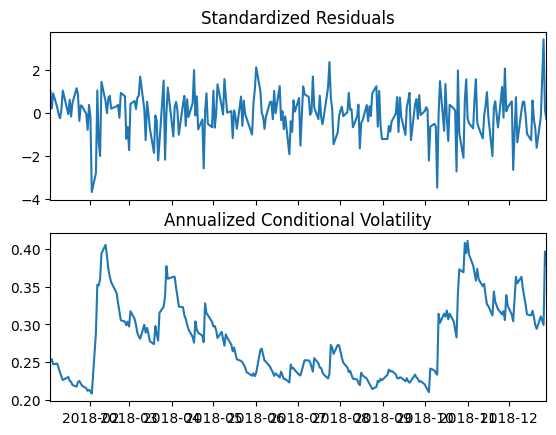

In [105]:
# Plot annualised vol
fig = model.plot(annualize='D')

In [106]:
# Forecast for next 60 days
model_forecast = model.forecast(horizon=60)

# Plot forecasted volatility
fdf = pd.DataFrame(np.sqrt(model_forecast.variance.dropna().T *252)*100)
fdf.columns = ['Conditional Volatility']
px.scatter(fdf, fdf.index, 'Conditional Volatility', labels={'index':'Horizon'}, title='GARCH Volatility Forecast')

c:\Users\HarrisonK\AppData\Local\anaconda3\envs\cqf\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning:


The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.


